In [46]:
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
from collections import deque
import os
import matplotlib.pyplot as plt

1) More actions, less actions: What are appropriate number of actions to discretise the range -2.0 to 2.0?
2) Stability of training, i.e. should you train longer or cut it off within some number of episodes?
3) Track the reward, save weights, plot performance. Reproduce your best possible agent by loading your best weights and test it for say, 10 times. Does it consistently balance the pendulum for all 10 times when tested?
4) Exploration vs exploitation (the epsilon hyperparameter). Should you decay it?
5) Explain the differences between this code and the lab code for cartpole.

# NO NEED GPU! CPU will do!

In [47]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [59]:
class DQN:
    def __init__(self,
                 InputShape = 4,
                 NActions = 2,
                 Gamma = 0.95,  # Discount rate
                 epsilon = 1.0,  # Exploration rate
                 epsilon_min = 0.1,
                 epsilon_decay = 0.995,
                 learning_rate = 0.01,
                 ReplayMemorySize = 10000,
                 MinReplayMemory = 1000,
                 UpdateTargetEveryThisEpisodes = 1,
                 IntermediateSize = 64,
                 BatchSize = 32):
        
        # Hyperparameters. #
        
        self.InputShape = InputShape
        self.NActions = NActions
        self.Gamma = Gamma
        self.ReplayMemorySize = ReplayMemorySize
        self.MinReplayMemory = MinReplayMemory
        self.UpdateTargetEveryThisEpisodes = UpdateTargetEveryThisEpisodes
        self.IntermediateSize = IntermediateSize
        self.BatchSize = BatchSize
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        
        self.total_reward = 0  # Initialize total reward accumulator
        self.episode_rewards = []  # List to store rewards for each episode
        self.average_rewards = []
    


        # Main model. #
        
        self.Main = self.CreateModel('Main')
        self.Optimiser = Adam()
        
        # Target model. #
        
        self.Target = self.CreateModel('Target')
        self.Target.set_weights(self.Main.get_weights())
        
        # Replay memory. #
        
        self.ReplayMemory = deque(maxlen = ReplayMemorySize)
        
        # Target network update counter. #
        
        self.TargetUpdateCounter = 0

    def save_weights(self, dir_path):
        print(f'Saving weights to {dir_path}')
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        Main_path = os.path.join(dir_path, 'Main')
        Target_path = os.path.join(dir_path, 'Target')
        self.Main.save_weights(Main_path + '_main.weights.h5')
        self.Target.save_weights(Target_path + '_target.weights.h5')
    
    
    def load_weights(self, path):
        print(f'Loading weights from {path}')
        Main_path = os.path.join(path, 'Main')
        Target_path = os.path.join(path, 'Target')
        self.Main.load_weights(Main_path + '_main.weights.h5')
        self.Target.load_weights(Target_path + '_target.weights.h5')

    def moving_average (self, values, window):
        weights = np.repeat(1.0, window)/window
        return np.convolve(values, weights, 'valid')
    
    def plot_rewards(self):
        plt.figure(figsize=(20, 5))
        plt.plot(self.episode_rewards, marker='o')
        plt.plot(self.moving_average(self.episode_rewards, 10), marker='o')
        plt.title('Episode Rewards')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.grid(True)
        plt.show()

    def plot_avg_rewards(self):
        plt.figure(figsize=(20, 5))
        plt.plot(self.average_rewards, marker='o')
        plt.plot(self.moving_average(self.average_rewards, 10), marker='o')
        plt.title('Episode Rewards')
        plt.xlabel('Episode')
        plt.ylabel('Average Reward')
        plt.grid(True)
        plt.show()


    def CreateModel(self, Type):
        inputs = Input(shape = (self.InputShape,), name = 'Input')
        x = Dense(self.IntermediateSize, activation = 'relu', name = '1stHiddenLayer')(inputs)
        x = Dense(self.IntermediateSize, activation = 'relu', name = '2ndHiddenLayer')(x)
        outputs = Dense(self.NActions, activation = 'linear', name = 'Output')(x)
        
        NN = Model(inputs, outputs, name = f'{Type}')
        NN.summary()
        
        return NN
    
    def UpdateReplayMemory(self, Information): # Information = (state, action, reward, SNext, Done)
        self.ReplayMemory.append(Information)

        # Epsilon-Greedy Policy to choose action
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            # pull random action (exploration)
            return random.randrange(self.action_size)
        # else pull current-best action (greedy; exploitation)
        act_values = self.model.predict(state, verbose = 0)
        return np.argmax(act_values[0])


    def Train(self, EndOfEpisode, reward):
        self.total_reward += reward  # Accumulate reward for the current episode

        # Only train if replay memory has enough data. #
        
        if len(self.ReplayMemory) < self.MinReplayMemory:
            print(f'DID NOT TRAIN..., replay memory = {len(self.ReplayMemory)}')
            return
        
        # Get batch of data for training. #
        
        TrainingData = random.sample(self.ReplayMemory, self.BatchSize)
        
        # Get states from training data, then get corresponding Q values. #
        
        ListOfS = np.array([element[0] for element in TrainingData])
        ListOfQ = np.array(self.Main(ListOfS))
        
        # Get future states from training data, then get corresponding Q values. #
        
        ListOfSNext = np.array([element[3] for element in TrainingData])
        ListOfQNext = self.Target(ListOfSNext)
        
        # Build actual training data for neural network. #
        
        X = []
        Y = []
        for index, (state, action, reward, SNext, Done) in enumerate(TrainingData):
            if not Done:
                MaxQNext = np.max(ListOfQNext[index])
                QNext = reward + self.Gamma * MaxQNext
            else:
                QNext = reward
            Q = ListOfQ[index]
            Q[action] = QNext
        
            X.append(state)
            Y.append(Q)
        
        # Train model using tf.GradientTape(), defined below.
    
        self.GTfit(X, Y)
                
        # Update target network every episode. #
        
        if EndOfEpisode:
            self.episode_rewards.append(self.total_reward)  # Store total reward for the episode
            self.total_reward = 0  # Reset total reward for the next episode
            self.TargetUpdateCounter += 1

        
        # Update target if counter is full. #
        
        if self.TargetUpdateCounter >= self.UpdateTargetEveryThisEpisodes:
            self.Target.set_weights(self.Main.get_weights())
            self.TargetUpdateCounter = 0

        # Decay epsilon gradually
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


    # This is the tf.GradientTape() which significantly speeds up training of neural networks
    @tf.function
    def GTfit(self, X, Y):
        
        # Train the neural network with this batch of data. #
        
        with tf.GradientTape() as tape:
            Predictions = self.Main(tf.convert_to_tensor(X), training = True)
            Loss = tf.math.reduce_mean(tf.math.square(tf.convert_to_tensor(Y) - Predictions))
        Grad = tape.gradient(Loss, self.Main.trainable_variables)
        self.Optimiser.apply_gradients(zip(Grad, self.Main.trainable_variables))

In [49]:
EnvName = 'Pendulum-v0'
IntermediateSize = 64
Epsilon = 1
ShowEvery = 10
InputShape = 3
NActions = 40


In [50]:
def PendulumActionConverter(action, NActions=NActions):
    ActualTorque = (action / NActions - 0.5) * 4
    return ActualTorque

def PendulumInverseActionConverter(action, NActions=NActions):
    ActualA = round((action + 2) * (NActions - 1) / 4)
    return(ActualA)

def OneEpisode(DQN):
    env = gym.make(f'{EnvName}')
    state = env.reset()
    ListOfRewards = []
    Done = False
    while not Done:
        Q = DQN.Main(state.reshape(-1, state.shape[0]))
        if np.random.rand() < Epsilon:
            AStep = env.action_space.sample()
            action = PendulumInverseActionConverter(AStep[0])
        else:
            action = np.argmax(Q)
            action = PendulumActionConverter(action)
            AStep = np.array([action])
            action = PendulumInverseActionConverter(action)
        if not _ % ShowEvery and len(DQN.ReplayMemory) >= DQN.MinReplayMemory:
            env.render()
        SNext, reward, Done, Info = env.step(AStep)
        DQN.UpdateReplayMemory((state, action, reward, SNext, Done))
        DQN.Train(Done, reward)
        ListOfRewards.append(reward)
        # all_rewards.append(reward)
        # all_sum_rewards.append(np.sum(ListOfRewards))
        if Done:
            print(f'Finished! | Return: {np.sum(ListOfRewards)} | average reward: {np.mean(ListOfRewards)}')
            env.close()
            return np.sum(ListOfRewards)
        state = SNext

Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 64)             │         4,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,576 (33.50 KB)

 Trainable params: 8,576 (33.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 64)             │         4,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,576 (33.50 KB)

 Trainable params: 8,576 (33.50 KB)

 Non-trainable params: 0 (0.00 B)

Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27


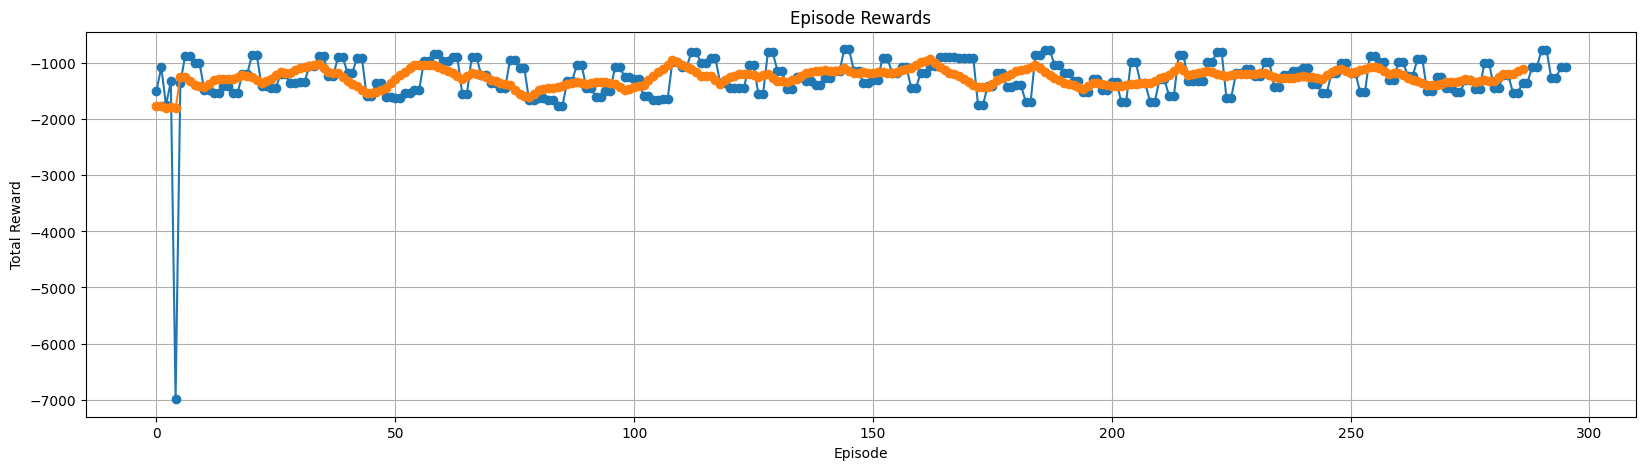

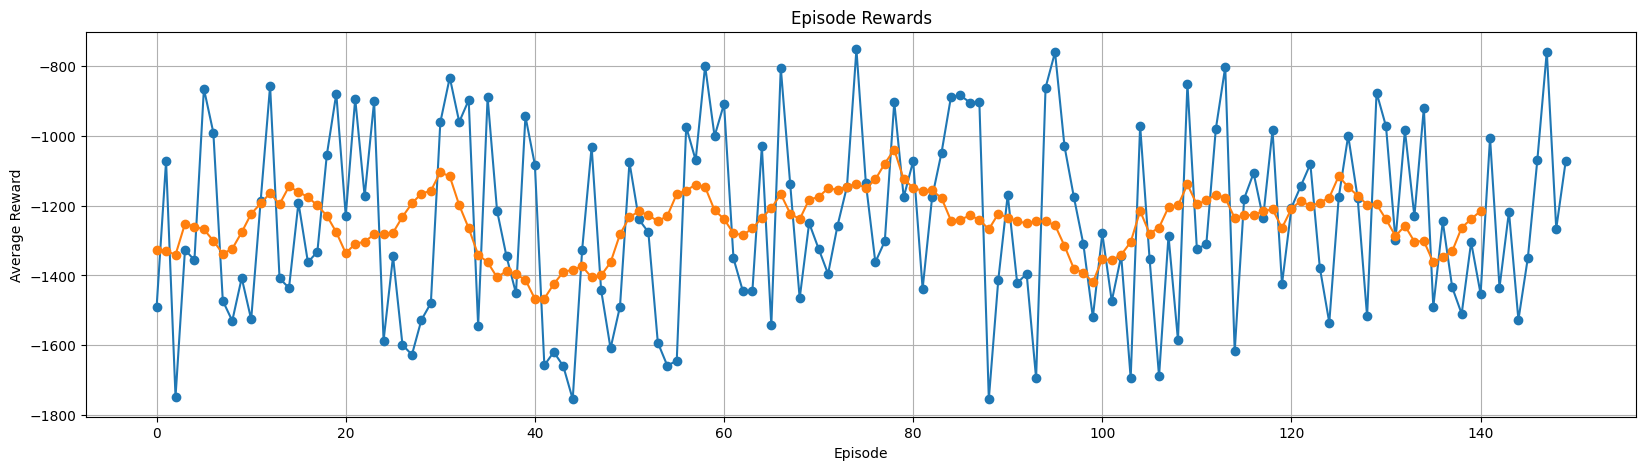

In [62]:
import time
STARTTIME = time.time()

dqn = DQN(InputShape = InputShape, NActions = NActions)
# dir_path='best_dqn_weights'
# dqn.load_weights(path=dir_path)

EPISODES = 150
best_reward = -1000
avg_reward = []
for _ in range(EPISODES):
    print(f'Episode {_}')
    reward = OneEpisode(dqn)
    dqn.episode_rewards.append(reward)
    dqn.average_rewards.append(np.mean(reward))
    print(f'Best reward: {best_reward}')
    if reward > best_reward:
        best_reward = reward
        dir_path = 'best_dqn_weights'
        print(f'Saving best model weights for episode {_} with reward {best_reward}')
        dqn.save_weights(dir_path=dir_path)

 
        


print(f'Total time taken: {time.time() - STARTTIME} seconds ...')


# Plot rewards
dqn.plot_rewards()

dqn.plot_avg_rewards()



In [ ]:
dqn = DQN(InputShape = InputShape, NActions = NActions)

# Test the best agent by loading the best weights
dir_path = 'best_dqn_weights'

dqn.load_weights(path=dir_path)
test_episodes = 10
test_rewards = []
for _ in range(test_episodes):
    print(f'Episode {_}')
    reward = OneEpisode(dqn)
    test_rewards.append(reward)

print(f'Test Rewards: {test_rewards}')
print(f'Average Test Reward: {np.mean(test_rewards)}')

env = gym.make(f'{EnvName}')
state = env.reset()
ListOfRewards = []
Done = False
while not Done:
    Q = dqn.Main(state.reshape(-1, state.shape[0]))
    action = np.argmax(Q)
    action = PendulumActionConverter(action)
    AStep = np.array([action])
    action = PendulumInverseActionConverter(action)
    env.render()
    SNext, reward, Done, Info = env.step(AStep)
    # DQN.UpdateReplayMemory((state, action, reward, SNext, Done))
    # DQN.Train(Done, reward)
    # ListOfRewards.append(reward)
    # all_rewards.append(reward)
    # all_sum_rewards.append(np.sum(ListOfRewards))
    state = SNext

Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 64)             │         4,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,576 (33.50 KB)

 Trainable params: 8,576 (33.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 64)             │         4,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,576 (33.50 KB)

 Trainable params: 8,576 (33.50 KB)

 Non-trainable params: 0 (0.00 B)

Loading weights from best_dqn_weights
Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26

In [ ]:
hyperparameters = {
    'EnvName': EnvName,
    'IntermediateSize': IntermediateSize,
    'Epsilon': Epsilon,
    'ShowEvery': ShowEvery,
    'InputShape': InputShape,
    'NActions': NActions
}

dqn = DQN(InputShape = InputShape, NActions = NActions)

# Test the best agent by loading the best weights
dir_path = 'best_dqn_weights'

dqn.load_weights(path=dir_path)
test_episodes = 10
test_rewards = []
for _ in range(test_episodes):
    print(f'Episode {_}')
    reward = OneEpisode(dqn)
    test_rewards.append(reward)

print(f'Test Rewards: {test_rewards}')
print(f'Average Test Reward: {np.mean(test_rewards)}')

env = gym.make(f'{EnvName}')
state = env.reset()
ListOfRewards = []
Done = False
while not Done:
    Q = dqn.Main(state.reshape(-1, state.shape[0]))
    action = np.argmax(Q)
    action = PendulumActionConverter(action)
    AStep = np.array([action])
    action = PendulumInverseActionConverter(action)
    env.render()
    SNext, reward, Done, Info = env.step(AStep)

    state = SNext

print(f'Hyperparameters: {hyperparameters}')
print(f'Test Rewards: {test_rewards}')
print(f'Average Test Reward: {np.mean(test_rewards)}')

env.close()

Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 64)             │         4,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,576 (33.50 KB)

 Trainable params: 8,576 (33.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 64)             │         4,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,576 (33.50 KB)

 Trainable params: 8,576 (33.50 KB)

 Non-trainable params: 0 (0.00 B)

Loading weights from best_dqn_weights
Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26

Exception ignored in: <function Viewer.__del__ at 0x0000025DEF332700>
Traceback (most recent call last):
  File "c:\Users\adamt\anaconda3\envs\RL\Lib\site-packages\gym\envs\classic_control\rendering.py", line 165, in __del__
    self.close()
  File "c:\Users\adamt\anaconda3\envs\RL\Lib\site-packages\gym\envs\classic_control\rendering.py", line 83, in close
    self.window.close()
  File "c:\Users\adamt\anaconda3\envs\RL\Lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "c:\Users\adamt\anaconda3\envs\RL\Lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "c:\Users\adamt\anaconda3\envs\RL\Lib\_weakrefset.py", line 113, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x0000025DF7CBFCE0; to 'Win32Window' at 0x0000025DF77458E0>


Hyperparameters: {'EnvName': 'Pendulum-v0', 'IntermediateSize': 64, 'Epsilon': 1, 'ShowEvery': 10, 'InputShape': 3, 'NActions': 64}
Test Rewards: [-871.1316415977528, -868.0568041908923, -796.8912131200883, -1183.7228842444347, -1344.5236833129557, -1131.5160510304652, -991.4842212792888, -1382.4719347020405, -1162.4819824515096, -1158.5210426107615]
Average Test Reward: -1089.0801458540186


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class Actor(tf.keras.Model):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(Actor, self).__init__()
        self.dense1 = layers.Dense(hidden_size, activation='relu')
        self.dense2 = layers.Dense(hidden_size, activation='relu')
        self.out = layers.Dense(action_size, activation='tanh')

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return self.out(x)

class Critic(tf.keras.Model):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(Critic, self).__init__()
        self.dense1 = layers.Dense(hidden_size, activation='relu')
        self.dense2 = layers.Dense(hidden_size, activation='relu')
        self.out = layers.Dense(1)

    def call(self, x, a):
        x = self.dense1(tf.concat([x, a], axis=1))
        x = self.dense2(x)
        return self.out(x)


In [ ]:
from collections import deque
import random
import numpy as np

class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self):
        experiences = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)
        return (np.array(states),
                np.array(actions),
                np.array(rewards),
                np.array(next_states),
                np.array(dones))

    def __len__(self):
        return len(self.buffer)


In [ ]:
class DDPGAgent:
    def __init__(self, state_size, action_size, hidden_size=64, lr_actor=0.001, lr_critic=0.002, gamma=0.99,
                 buffer_size=10000, batch_size=64, tau=0.005):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size

        self.actor_local = Actor(state_size, action_size, hidden_size)
        self.actor_target = Actor(state_size, action_size, hidden_size)
        self.actor_target.set_weights(self.actor_local.get_weights())

        self.critic_local = Critic(state_size, action_size, hidden_size)
        self.critic_target = Critic(state_size, action_size, hidden_size)
        self.critic_target.set_weights(self.critic_local.get_weights())

        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_actor)
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_critic)
        self.replay_buffer = ReplayBuffer(buffer_size, batch_size)

    def update_target_network(self, local_model, target_model):
        for target_param, local_param in zip(target_model.trainable_variables, local_model.trainable_variables):
            target_param.assign(self.tau * local_param + (1.0 - self.tau) * target_param)

    def act(self, state, noise_scale):
        state = np.expand_dims(state, axis=0).astype(np.float32)
        action = self.actor_local(state).numpy()[0]
        action += noise_scale * np.random.randn(self.action_size)
        return np.clip(action, -1, 1)

    def learn(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample()

        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)

        # Update critic
        next_actions = self.actor_target(next_states)
        next_q_values = self.critic_target(next_states, next_actions)
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))
        with tf.GradientTape() as tape:
            q_values = self.critic_local(states, actions)
            critic_loss = tf.reduce_mean(tf.square(target_q_values - q_values))
        critic_gradients = tape.gradient(critic_loss, self.critic_local.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_gradients, self.critic_local.trainable_variables))

        # Update actor
        with tf.GradientTape() as tape:
            actions_pred = self.actor_local(states)
            actor_loss = -tf.reduce_mean(self.critic_local(states, actions_pred))
        actor_gradients = tape.gradient(actor_loss, self.actor_local.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_gradients, self.actor_local.trainable_variables))

        # Update target networks
        self.update_target_network(self.actor_local, self.actor_target)
        self.update_target_network(self.critic_local, self.critic_target)


In [ ]:
def train_and_evaluate(alpha_actor, alpha_critic, gamma, tau, num_training_episodes=500, num_evaluation_episodes=100, noise_scale=0.1):
    env = gym.make('Pendulum-v0')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.shape[0]

    agent = DDPGAgent(state_size, action_size, lr_actor=alpha_actor, lr_critic=alpha_critic, gamma=gamma, tau=tau)

    # Training loop
    for episode in range(num_training_episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = agent.act(state, noise_scale)
            next_state, reward, done, _ = env.step(action)
            agent.replay_buffer.add((state, action, reward, next_state, done))
            agent.learn()
            state = next_state
            episode_reward += reward

        noise_scale *= 0.99  # Decay noise scale

    # Evaluation loop
    total_rewards = []
    for episode in range(num_evaluation_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        best_reward = -9999999
        while not done:
            action = agent.act(state, noise_scale=0.0)  # No noise during evaluation
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state
            print(episode, total_reward)
            if reward > best_reward:
                best_reward = total_reward
                dir_path = 'best_ddqn_weights'
                print(f'Saving best model weights for episode {_} with reward {best_reward}')
                dqn.save_weights(dir_path=dir_path)
        
        total_rewards.append(total_reward)

    average_reward = np.mean(total_rewards)
    return average_reward

# Example usage
alpha_actor = 0.001
alpha_critic = 0.002
gamma = 0.99
tau = 0.005

average_reward = train_and_evaluate(alpha_actor, alpha_critic, gamma, tau)
print(f'Average Reward: {average_reward}')


KeyboardInterrupt: 